In [1]:
import pandas as pd
from google.cloud import bigquery
%load_ext google.cloud.bigquery

from IPython.display import clear_output
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.5)
#sns.set_style('darkgrid', {"xtick.minor.size": 10, "ytick.major.size": 10})
current_palette = sns.color_palette('deep')
#sns.palplot(current_palette)

In [ ]:
for i in range(10):
    time.sleep(0.5)
    clear_output(wait=True)
    print("This is {} iteration!".format(i))


# 1. A Word on Family Types

### 1.1. DOCDB family (simple family, or Espacenet patent family)

All applications of the same simple family do have the **same priorities**. The technical content of these family members is regarded as **(almost) identical**, so their publications are sometimes called “equivalent”.

A DOCDB family means that most probably the applications **share exactly the same priorities** (Paris Convention or technical relation or others) as contained in table `TLS201_APPLN`, `TLS204_PRIOR_APPLN`, `TLS205_TECH_REL` and `TLS216_APPLN_CONTN`.

**The simplified definition**: is that `all their priorities` must be the same. DOCDB family members generally refer to the same invention.


The EPO reserves the right to classify an application into a particular simple family irrespective of this general rule - the EPO does this by creating artificial priorities for an application or by ignoring certain priorities (declaring them “inactive”) for the purpose of family building.



By “priority” we here mean not only “Paris Convention priority”, but also other types of priorities which link one application to a “prior” application. The various types of priorities are stored in separate tables:
1. TLS201_APPLN An PCT application in its regional/national phase contains in its attribute INTERNAT_APPLN_ID the APPLN_ID of its original PCT application
2. TLS204_APPLN_PRIOR contains Paris Convention priorities
3. TLS205_TECH_REL contains links between technically equivalent applications
4. TLS216_APPLN_CONTN contains various relations like continuations, divisional applications, ...


### 1.2. INPADOC family (Extended family)

All applications of the same extended family are **directly or indirectly** linked to the **same root** priority application. Usually the applications are related to the same technical invention, but their individual content may differ.

Means that the applications **share a priority** `directly `or `indirectly` via a third application. 
A **'priority'** in this case means a **link shown** between applications as in tables `TLS201_APPLN` (regional/national phase of a PCT application), `TLS204_ APPLN_PRIOR` (PARIS convention priorities), `TLS205_TECH_REL` (patents which have been technically linked by patent examiners on the basis of similar content) and table `TLS216_ APPLN_CONTN` (continuations, divisions etc.).

**The simplified definition**: is that the `members relate in some way` (directly or indirectly) to the `"first" application`.

`For the dummy application (i.e. APPLN_ID = 0) and for artificial application replenished because of citations (i.e. APPLN_ID > 930 000 000) the value of the INPADOC_FAMILY_ID will be the same as the value of the APPLN_ID. Thus, each "appln_id" will have the family size of exactly one.`

## 2. Implementing the Algorithm

This Algorithm has the following steps:
0. Take the table of `priorities` and `applications` as inputs.
1. For each primary priority filing, i.e. the priority filing that has no prior, add `(prior_appln, prior_appln)` to the `priorities` table.
2. While there exists some rows that have been updated:
3.    1. (I need to also incorporate the effect of `appln_auth` in updating) Update the prior of each `appln_id` if the priors of `appln_id` covers all the secondary filings of the next prior.
4. For the `appln_id`s that are pointing to the same set of priors (more than one obviously) but doesn't have the same `appln_auth`, choose an arbitrary `prior_id`.
5. For the `appln_id`s that are pointing to the same prior (or priors) and have the same `appln_auth`, change their priors to their `appln_id`
6. (You don't need to do this step, since you changed the prior_id of these cases in the previous step) Remove `appln_id`s that have the same `priors` and `appln_auth`
7. Return the list of priors for each appln_id, as the family id

In [11]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id = 'test204'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query = """
SELECT 2 AS appln_id, 1 AS prior_appln_id UNION ALL
SELECT 3, 1 UNION ALL
SELECT 4, 2 UNION ALL
SELECT 5, 2 UNION ALL
SELECT 6, 3 UNION ALL
SELECT 7, 4 UNION ALL
SELECT 7, 5 UNION ALL
SELECT 8, 5 UNION ALL
SELECT 8, 6 UNION ALL
SELECT 9, 7 UNION ALL
SELECT 10, 8
"""
# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [10]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id = 'test201'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query = """
SELECT 1 AS appln_id, 'EP' AS appln_auth UNION ALL
SELECT 2, 'US' UNION ALL
SELECT 3, 'US' UNION ALL
SELECT 4, 'KR' UNION ALL
SELECT 5, 'KR' UNION ALL
SELECT 6, 'JP' UNION ALL
SELECT 7, 'DK' UNION ALL
SELECT 8, 'GB' UNION ALL
SELECT 9, 'CN' UNION ALL
SELECT 10, 'FR'
"""
# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

### 2.1. Adding (appln_id, prior_appln_id) data for the Priority filings

In [1]:
client = bigquery.Client()

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id = 'step_01'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref


#table_1 = "`usptobias.patstat.tls204`"
#table_2 = "`usptobias.patstat.tls201`"
# These tables are for the sake of examples
table_1 = "`usptobias.custom_alg.test204`"
table_2 = "`usptobias.custom_alg.test201`"

query = """
SELECT 
        appln_id, prior_appln_id, appln_auth, 1 AS updated
FROM (
        SELECT appln_id, prior_appln_id, appln_auth
        FROM {}
        LEFT JOIN (
                SELECT appln_id, appln_auth
                FROM {}
        ) USING(appln_id)
)
UNION ALL (
        SELECT 
                t2.appln_id AS appln_id, 
                t2.appln_id AS prior_appln_id,
                t2.appln_auth AS appln_auth,
                1 AS updated
        FROM {} AS t1
        RIGHT JOIN (
                SELECT appln_id, appln_auth
                FROM {}
                ) AS t2 ON t1.appln_id=t2.appln_id
        WHERE t1.appln_id IS NULL
)
     """.format(table_1, table_2, table_1, table_2)
# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

### 2.2. Building "table1" and "table2" 

- `table_a` : contains `"group_by_AP"` column, which lists all the  "appln_id" with the same **appln_auth** that are pointing to the same **prior_appln_id**
- `table_b` : contains `"priors_list"` column, which lists all the "prior_appln_id"s that each **appln_id** is pointing to.

In [80]:
## Creating table_a
table_1 = '`usptobias.custom_alg.step_01`'

client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id='step_02_table_a'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref


query="""
SELECT *
FROM {}
LEFT JOIN(
        SELECT prior_appln_id, appln_auth, ARRAY_AGG(DISTINCT appln_id ORDER BY appln_id) AS group_by_AP
        FROM {}
        GROUP BY prior_appln_id, appln_auth
) USING(prior_appln_id, appln_auth)

""".format(table_1, table_1)

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [81]:
## Creating table_b
table_1 = '`usptobias.custom_alg.step_01`'

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id='step_02_table_b'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref


query="""
SELECT *
FROM {}
LEFT JOIN(
        SELECT appln_id, ARRAY_AGG(DISTINCT prior_appln_id ORDER BY prior_appln_id) AS priors_list
        FROM {}
        GROUP BY appln_id
) USING(appln_id)
""".format(table_1, table_1)

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

### 2.3. Joining `table_b` on `table_a`

In this step, we use `table_b` and joing it and `table_a`, this will gives us the chance to compare **priors_list** with **group_by_AP**. If, for a certain `appln_id`, all the elements of its **priors_list** column exist in **group_by_AP** column, it means that this specific application covers at least the same (or maybe broader) inventive steps (technical matter). Thus, we will substitute its priority by the second-level prioroty. 

In [82]:
## Joing "table_b" and "table_a" to get back 
table_b = '`usptobias.custom_alg.step_02_table_b`'
table_a = '`usptobias.custom_alg.step_02_table_a`'

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id='step_03_joined'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref


query= """
SELECT 
        b.appln_id,
        b.prior_appln_id AS prior_appln_b,
        a.prior_appln_id AS prior_appln_a,
        b.priors_list,
        a.group_by_AP,
        b.appln_auth
FROM {} as b
LEFT JOIN {} as a ON b.prior_appln_id=a.appln_id
""".format(table_b, table_a)

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [86]:
## Updating the "prior_appln_id"
table_1 = '`usptobias.custom_alg.step_03_joined`'

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
#table_id= 'step_03_updated'
table_id = 'step_01'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query="""
SELECT DISTINCT
    appln_id,
    appln_auth,
    (CASE WHEN z=0 THEN prior_appln_a ELSE prior_appln_b END) AS prior_appln_id,
    (CASE WHEN z=0 AND prior_appln_a<>prior_appln_b THEN 1 ELSE 0 END) AS updated
FROM 
    {} AS a,
    UNNEST([(
            SELECT ARRAY_LENGTH(a.group_by_AP) - COUNT(1) 
            FROM UNNEST(a.group_by_AP) AS x
            JOIN UNNEST(a.priors_list) AS y
            ON x=y)]) AS z
""".format(table_1)

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

### Now this part is after finishing while

In [94]:
## Replacing the priors of "appln_id" with more than one member in their "group_by_AP"
table_1 = '`usptobias.custom_alg.step_01`'

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id='step_04_changed_same_AP'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query="""
SELECT
    appln_id,
    appln_auth,
    (CASE WHEN ARRAY_LENGTH(group_by_AP)=1 THEN prior_appln_id ELSE appln_id END) AS prior_appln_id
FROM {} AS a
LEFT JOIN(
        SELECT prior_appln_id, appln_auth, ARRAY_AGG(DISTINCT appln_id ORDER BY appln_id) AS group_by_AP
        FROM {}
        GROUP BY prior_appln_id, appln_auth
) USING(prior_appln_id, appln_auth)

""".format(table_1, table_1)

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [102]:
# Replacing the "prior_appln_id" of those that are pointing to more than one priors and the same ones!
table_1='`usptobias.custom_alg.step_04_changed_same_AP`'

# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id = "step_5_final"
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref


query="""
WITH a AS(
    SELECT 
        *
    FROM `usptobias.custom_alg.step_04_changed_same_AP`
    LEFT JOIN(
            SELECT 
                appln_id, 
                ARRAY_AGG(DISTINCT prior_appln_id ORDER BY prior_appln_id) AS priors_list,
                TO_JSON_STRING(ARRAY_AGG(DISTINCT prior_appln_id ORDER BY prior_appln_id)) AS priors_str
            FROM `usptobias.custom_alg.step_04_changed_same_AP`
            GROUP BY appln_id
    ) USING(appln_id)
)
SELECT DISTINCT
    appln_id,
    appln_auth,
    family_id
FROM(
    SELECT 
        appln_id,
        appln_auth,
        b.prior_appln_id
    FROM a
    LEFT JOIN(
        SELECT
            priors_str,
            ANY_VALUE(priors_list) AS priors_list,
            (CASE WHEN ARRAY_LENGTH(ANY_VALUE(priors_list))>1 THEN ARRAY_AGG(DISTINCT appln_id ORDER BY appln_id LIMIT 1) ELSE ANY_VALUE(priors_list) END) AS prior_appln_id
        FROM a
        GROUP BY priors_str
    ) AS b USING(priors_str)
) AS t1, UNNEST(t1.prior_appln_id) AS family_id

ORDER BY family_id
""".format(table_1, table_1)

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

# Now, everything Together:

In [3]:
def add_priorites(t204="`usptobias.patstat.tls204`", t201="`usptobias.patstat.test201`", table_id='step_01', dataset_id = 'custom_alg'):
    client = bigquery.Client()

    # Creating Job Config
    job_config = bigquery.QueryJobConfig()
    #job_config.dry_run = True
    job_config.use_query_cache = False
    # Set configuration.query.writeDisposition
    job_config.write_disposition = 'WRITE_TRUNCATE'

    # Set the destination table
    table_ref = client.dataset(dataset_id).table(table_id)
    job_config.destination = table_ref

    query = """
    SELECT DISTINCT
            appln_id, prior_appln_id, appln_auth, 1 AS updated
    FROM (
            SELECT appln_id, prior_appln_id, appln_auth
            FROM {}
            LEFT JOIN (
                    SELECT appln_id, appln_auth
                    FROM {}
            ) USING(appln_id)
    )
    UNION ALL (
            SELECT 
                    t2.appln_id AS appln_id, 
                    t2.appln_id AS prior_appln_id,
                    t2.appln_auth AS appln_auth,
                    1 AS updated
            FROM {} AS t1
            RIGHT JOIN (
                    SELECT appln_id, appln_auth
                    FROM {}
                    ) AS t2 ON t1.appln_id=t2.appln_id
            WHERE t1.appln_id IS NULL
    )
         """.format(t204, t201, t204, t201)
    # Defining the query
    query_job = client.query(query, location='US', job_config=job_config)

    query_job.result()
    
    return None

In [4]:
def update_priorities(t1 ='`usptobias.custom_alg.step_01`', table_id='step_01', dataset_id = 'custom_alg'):

    client = bigquery.Client()
    # Creating Job Config
    job_config = bigquery.QueryJobConfig()
    #job_config.dry_run = True
    job_config.use_query_cache = False
    # Set configuration.query.writeDisposition
    job_config.write_disposition = 'WRITE_TRUNCATE'

    # Set the destination table
    table_ref = client.dataset(dataset_id).table(table_id)
    job_config.destination = table_ref

    query="""
    WITH t0 AS(
        SELECT DISTINCT appln_id, prior_appln_id, appln_auth
        FROM {}
    ), a AS(
        SELECT *
        FROM t0
        LEFT JOIN(
                SELECT prior_appln_id, appln_auth, ARRAY_AGG(DISTINCT appln_id ORDER BY appln_id) AS group_by_AP
                FROM t0
                GROUP BY prior_appln_id, appln_auth
        ) USING(prior_appln_id, appln_auth)
    ), b AS(
        SELECT *
        FROM t0
        LEFT JOIN(
                SELECT appln_id, ARRAY_AGG(DISTINCT prior_appln_id ORDER BY prior_appln_id) AS priors_list
                FROM t0
                GROUP BY appln_id
        ) USING(appln_id)
    ), joined AS(
        SELECT 
                b.appln_id,
                b.prior_appln_id AS prior_appln_b,
                a.prior_appln_id AS prior_appln_a,
                b.priors_list,
                a.group_by_AP,
                b.appln_auth
        FROM b
        LEFT JOIN a ON b.prior_appln_id=a.appln_id
    )

    SELECT DISTINCT
        appln_id,
        appln_auth,
        (CASE WHEN z=0 THEN prior_appln_a ELSE prior_appln_b END) AS prior_appln_id,
        (CASE WHEN z=0 AND prior_appln_a<>prior_appln_b THEN 1 ELSE 0 END) AS updated
    FROM 
        joined AS c,
        UNNEST([(
                SELECT ARRAY_LENGTH(c.group_by_AP) - COUNT(1) 
                FROM UNNEST(c.group_by_AP) AS x
                JOIN UNNEST(c.priors_list) AS y
                ON x=y)]) AS z

    """.format(t1)
    
    # Defining the query
    query_job = client.query(query, location='US', job_config=job_config)

    query_job.result()
    
    return None

In [5]:
def to_continue(table_id='step_01', dataset_id= 'custom_alg'):
    t1 ='`usptobias.{}.{}`'.format(dataset_id,table_id)
    client = bigquery.Client()

    query="""
    SELECT SUM(updated) AS sum_updated, COUNT(updated) AS nb_rows
    FROM {}
    """.format(t1)
    
    # Defining the query
    return client.query(query).to_dataframe()
    

In [6]:
def computing_family(t1 = '`usptobias.custom_alg.step_02_final`', table_id='step_02_final', dataset_id = 'custom_alg'):
    client = bigquery.Client()
    # Creating Job Config
    job_config = bigquery.QueryJobConfig()
    #job_config.dry_run = True
    job_config.use_query_cache = False
    # Set configuration.query.writeDisposition
    job_config.write_disposition = 'WRITE_TRUNCATE'

    # Set the destination table
    table_ref = client.dataset(dataset_id).table(table_id)
    job_config.destination = table_ref
    query="""
    WITH b AS(
        SELECT
            appln_id,
            appln_auth,
            (CASE WHEN ARRAY_LENGTH(group_by_AP)=1 THEN prior_appln_id ELSE appln_id END) AS prior_appln_id
        FROM {} AS a
        LEFT JOIN(
                SELECT prior_appln_id, appln_auth, ARRAY_AGG(DISTINCT appln_id ORDER BY appln_id) AS group_by_AP
                FROM {}
                GROUP BY prior_appln_id, appln_auth
        ) USING(prior_appln_id, appln_auth)
    ), a AS(
        SELECT 
            *
        FROM b
        LEFT JOIN(
                SELECT 
                    appln_id, 
                    ARRAY_AGG(DISTINCT prior_appln_id ORDER BY prior_appln_id) AS priors_list,
                    TO_JSON_STRING(ARRAY_AGG(DISTINCT prior_appln_id ORDER BY prior_appln_id)) AS priors_str
                FROM b
                GROUP BY appln_id
        ) USING(appln_id)
    )
    
    SELECT DISTINCT *
    FROM(
        SELECT DISTINCT
            appln_id,
            appln_auth,
            family_id
        FROM(
            SELECT 
                appln_id,
                appln_auth,
                c.prior_appln_id
            FROM a
            LEFT JOIN(
                SELECT
                    priors_str,
                    ANY_VALUE(priors_list) AS priors_list,
                    (CASE WHEN ARRAY_LENGTH(ANY_VALUE(priors_list))>1 THEN ARRAY_AGG(DISTINCT appln_id ORDER BY appln_id LIMIT 1) ELSE ANY_VALUE(priors_list) END) AS prior_appln_id
                FROM a
                GROUP BY priors_str
            ) AS c USING(priors_str)
        ) AS t1, UNNEST(t1.prior_appln_id) AS family_id
    )
    """.format(t1,t1)

    # Defining the query
    query_job = client.query(query, location='US', job_config=job_config)

    query_job.result()

In [20]:
def remove_cycles(t1='`usptobias.custom_alg.step_01`', table_id='step_02_final', dataset_id='custom_alg'):

    client = bigquery.Client()
    # Creating Job Config
    job_config = bigquery.QueryJobConfig()
    #job_config.dry_run = True
    job_config.use_query_cache = False
    # Set configuration.query.writeDisposition
    job_config.write_disposition = 'WRITE_TRUNCATE'

    # Set the destination table
    table_ref = client.dataset(dataset_id).table(table_id)
    job_config.destination = table_ref
    
    query="""
    WITH a AS(
        SELECT appln_id, ANY_VALUE(appln_auth) AS appln_auth, prior_appln_id, MIN(updated) AS updated
        FROM {}
        GROUP BY appln_id, prior_appln_id
    )
        SELECT DISTINCT *
        FROM a
        WHERE updated=0
    """.format(t1)

    # Defining the query
    query_job = client.query(query, location='US', job_config=job_config)

    query_job.result()
    
    return None

In [21]:
# Finding family ID
def finding_family(t204="`usptobias.patstat.tls204`", t201="`usptobias.patstat.tls201`", n_iter=16, table_mid='step_01', table_dis='step_02', dataset_id='custom_alg'):
    start_time = time.time()
    pbar = tqdm(total=100)
    continue_cond = pd.DataFrame(dict(sum_updated=[0], nb_rows=[0]))
    
    add_priorites(t204=t204, t201=t201, table_id=table_mid, dataset_id=dataset_id)
    pbar.update(10)
    
    for i in range(n_iter):
        update_priorities(t1 ='`usptobias.{}.{}`'.format(dataset_id,table_mid), table_id=table_mid, dataset_id=dataset_id)
        prev_updated = continue_cond.loc[0,'sum_updated']
        continue_cond = to_continue(table_id=table_mid, dataset_id=dataset_id)
        if not continue_cond.loc[0,'sum_updated']: #or (abs(prev_updated - continue_cond.loc[0,'sum_updated'])<0.00001*continue_cond.loc[0,'sum_updated']):
            clear_output(wait=True)
            pbar.update(int(80/n_iter))
            print('Remaining {:,}/{:,}\nThere are {:,} elements that has been finished in the previous step!'
                  .format(continue_cond.loc[0,'sum_updated'], continue_cond.loc[0,'nb_rows'], prev_updated - continue_cond.loc[0,'sum_updated']))
            break
        clear_output(wait=True)
        pbar.update(int(80/n_iter))
        print('Remaining {:,}/{:,}\nThere are {:,} elements that has been finished in the previous step!'
              .format(continue_cond.loc[0,'sum_updated'], continue_cond.loc[0,'nb_rows'], prev_updated - continue_cond.loc[0,'sum_updated']))
        
    if continue_cond.loc[0,'sum_updated']:
        remove_cycles(t1='`usptobias.{}.{}`'.format(dataset_id,table_mid), table_id=table_mid, dataset_id=dataset_id)
    pbar.n=90
    pbar.last_printed_n =90
    computing_family(t1 ='`usptobias.{}.{}`'.format(dataset_id,table_mid), table_id=table_dis, dataset_id=dataset_id)
    pbar.update(10)
    pbar.close()
    print('It took {:.2f} seconds in total.\nThe number of updates: {} times!'.format(time.time()-start_time, i+1))

## Creating family ID with only "Priority" information

In [29]:
# Creating the family_id using only "priority dataset"
finding_family(t204="`usptobias.patstat.tls204`", t201="`usptobias.patstat.tls201`", n_iter=10, table_mid='step_01', table_dis='step_02', dataset_id='custom_alg')

 90%|█████████ | 90/100 [17:04<01:54, 11.41s/it]

Remaining 164,677/104,086,027
There are 45 elements that has been finished in the previous step!


100%|██████████| 100/100 [20:43<00:00, 14.55s/it]

It took 1243.06 seconds in total.
The number of updates: 10 times!


## Creating Family ID using "Priority, Continuation, and Technical Rel"

In [99]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
table_id = 'tls204_PTC'
dataset_id= 'custom_alg'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref

query="""
SELECT appln_id, prior_appln_id
FROM `usptobias.patstat.tls204` UNION ALL
SELECT appln_id, tech_rel_appln_id AS prior_appln_id
FROM `usptobias.patstat.tls205` UNION ALL
SELECT appln_id, parent_appln_id AS prior_appln_id
FROM `usptobias.patstat.tls216`
"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()


In [36]:
# Creating the family ID using all the prior, continuation, and technical relation information
finding_family(t204="`usptobias.custom_alg.tls204_PTC`", t201="`usptobias.patstat.tls201`", n_iter=8, table_mid='step_01_PCT', table_dis='step_02_PCT', dataset_id='custom_alg')

 90%|█████████ | 90/100 [17:17<01:55, 11.59s/it]

Remaining 4,355,144/114,162,297
There are 54 elements that has been finished in the previous step!


100%|██████████| 100/100 [20:47<00:00, 14.42s/it]

It took 1247.87 seconds in total.
The number of updates: 8 times!


## Checking the difference between the two family ID

In [9]:
%%bigquery df_1
SELECT COUNT(CASE WHEN family_id_1<>family_id_2 THEN 1 END) AS nb_difference, COUNT(CASE WHEN family_id_1<>family_id_2 THEN 1 END) AS nb_same
FROM(
    SELECT appln_id, ANY_VALUE(t1.family_id) AS family_id_1, ANY_VALUE(t2.family_id) AS family_id_2
    FROM `usptobias.custom_alg.step_02_final` AS t1
    LEFT JOIN `usptobias.custom_alg.step_02_PCT` AS t2 USING(appln_id)
    GROUP BY appln_id
)

,nb_difference,nb_total
0,670407,96661355


## Building Family ID Using GOOGLE Patents Public Data

In [ ]:
# New edition

In [37]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id = 'tls204_google'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref
query="""
WITH t1 AS(
  SELECT a.application_number AS appln_nr_orig, PC.application_number AS prior_appln_nr_orig
  FROM `patents-public-data.patents.publications` AS a, UNNEST(a.priority_claim) AS PC
), t2 AS(
    SELECT *
    FROM `usptobias.adding_data.10_mapping`
)

SELECT a.*, t2.appln_id AS prior_appln_id
FROM(
    SELECT t1.*, t2.appln_id AS appln_id
    FROM t1
    INNER JOIN t2 ON t1.appln_nr_orig=t2.appln_nr_orig
) AS a
INNER JOIN t2 ON a.prior_appln_nr_orig=t2.appln_nr_orig

"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [ ]:
# Creating the family ID using Google Patents Public Dataset
finding_family(t204="`usptobias.custom_alg.tls204_google`", t201="`usptobias.patstat.tls201`", n_iter=8, 
               table_mid='step_01_google', table_dis='step_02_google', dataset_id='custom_alg')

# Checking The Quality of Computing Family IDs

In [39]:
%%bigquery df_1
SELECT 
    COUNT(CASE WHEN family_id_1<>family_id_2 THEN 1 END) AS nb_difference, 
    COUNT(CASE WHEN (family_id_1 IS NULL) OR (family_id_2 IS NULL) THEN 1 END) AS nb_NA,
    COUNT(CASE WHEN family_id_1=family_id_2 THEN 1 END) AS nb_same
FROM(
    SELECT appln_id, MAX(t1.family_id) AS family_id_1, MAX(t2.family_id) AS family_id_2
    FROM `usptobias.custom_alg.step_02` AS t1
    FULL OUTER JOIN `usptobias.custom_alg.step_02_PCT` AS t2 USING(appln_id)
    GROUP BY appln_id
)

,nb_difference,nb_NA,nb_same
0,676053,8,95985302


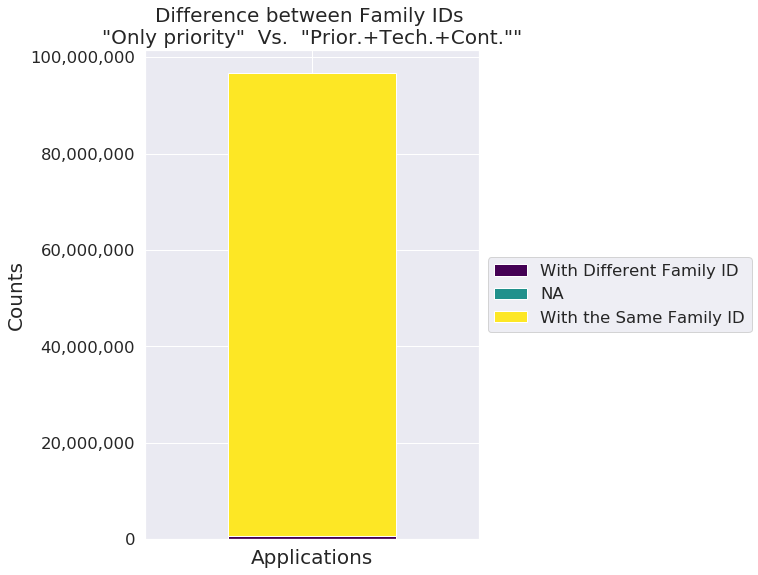

In [43]:
## Plotting the percentage of unchanged
fig, ax = plt.subplots(1, 1, figsize=(6,9))
df_1.index = ['Applications']
df_1.columns = ['With Different Family ID', 'NA', 'With the Same Family ID']
df_1.plot(ax=ax, kind='bar', stacked=True, colormap='viridis')
ax.bar
#ax.set_xlabel('Sex', fontsize=18)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('Difference between Family IDs \n"Only priority"  Vs.  "Prior.+Tech.+Cont.""', fontsize=20)
ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
#ax.set_yscale('log')
#ax.set_ylim(1e5,1e8)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':20}, rotation = 'horizontal')


plt.show()

In [ ]:
# Checking the difference between Patstat dataset and Google Patents Public Dataset

In [44]:
%%bigquery df_2
SELECT 
    COUNT(DISTINCT (CASE WHEN family_id_1<>family_id_2 THEN appln_id END)) AS nb_difference, 
    COUNT(DISTINCT (CASE WHEN family_id_1 IS NULL OR family_id_2 IS NULL THEN appln_id END)) AS nb_NA,
    COUNT(DISTINCT (CASE WHEN family_id_1=family_id_2 THEN appln_id END)) AS nb_same
FROM(
    SELECT appln_id, MAX(t1.family_id) AS family_id_1, MAX(t2.family_id) AS family_id_2
    FROM `usptobias.custom_alg.step_02` AS t1
    FULL OUTER JOIN `usptobias.custom_alg.step_02_google` AS t2 USING(appln_id)
    WHERE t1.appln_id IS NOT NULL OR t2.appln_id IS NOT NULL
    GROUP BY appln_id
)

,nb_difference,nb_NA,nb_same
0,2698000,8,93963355


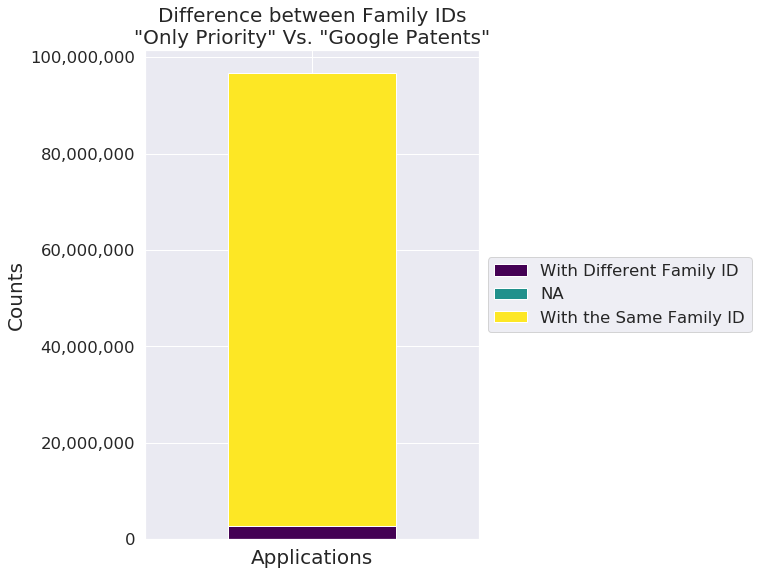

In [45]:
## Plotting the percentage of unchanged
fig, ax = plt.subplots(1, 1, figsize=(6,9))
df_2.index = ['Applications']
df_2.columns = ['With Different Family ID', 'NA', 'With the Same Family ID']
df_2.plot(ax=ax, kind='bar', stacked=True, colormap='viridis')
ax.bar
#ax.set_xlabel('Sex', fontsize=18)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('Difference between Family IDs\n"Only Priority" Vs. "Google Patents"', fontsize=20)
ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
#ax.set_yscale('log')
#ax.set_ylim(1e5,1e8)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':20}, rotation = 'horizontal')


plt.show()

In [46]:
%%bigquery df_3
SELECT 
    COUNT(DISTINCT (CASE WHEN family_id_1<>family_id_2 THEN appln_id END)) AS nb_difference, 
    COUNT(DISTINCT (CASE WHEN family_id_1 IS NULL OR family_id_2 IS NULL THEN appln_id END)) AS nb_NA,
    COUNT(DISTINCT (CASE WHEN family_id_1=family_id_2 THEN appln_id END)) AS nb_same
FROM(
    SELECT appln_id, MAX(t1.family_id) AS family_id_1, MAX(t2.family_id) AS family_id_2
    FROM `usptobias.custom_alg.step_02_PCT` AS t1
    FULL OUTER JOIN `usptobias.custom_alg.step_02_google` AS t2 USING(appln_id)
    WHERE t1.appln_id IS NOT NULL OR t2.appln_id IS NOT NULL
    GROUP BY appln_id
)

,nb_difference,nb_NA,nb_same
0,2697759,0,93963604


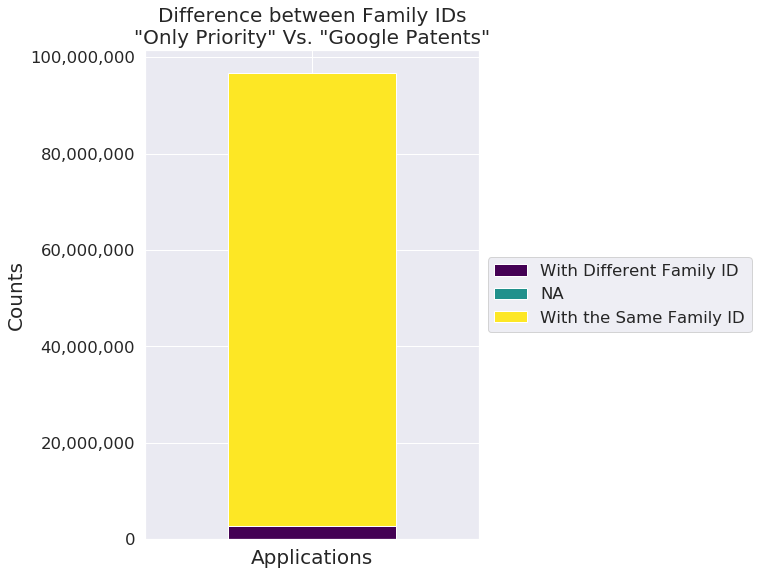

In [48]:
## Plotting the percentage of unchanged
fig, ax = plt.subplots(1, 1, figsize=(6,9))
df_3.index = ['Applications']
df_3.columns = ['With Different Family ID', 'NA', 'With the Same Family ID']
df_3.plot(ax=ax, kind='bar', stacked=True, colormap='viridis')
ax.bar
#ax.set_xlabel('Sex', fontsize=18)
ax.set_ylabel('Counts', fontsize=20)
ax.set_title('Difference between Family IDs\n"Only Priority" Vs. "Google Patents"', fontsize=20)
ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
#ax.set_yscale('log')
#ax.set_ylim(1e5,1e8)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':20}, rotation = 'horizontal')


plt.show()

# Visualizing the resulted Family ID

## Number of families in total!

In [ ]:
## QUERY-1-A: finding total number of families detected

In [9]:
%%bigquery df_
SELECT 
    COUNT(DISTINCT family_id) AS nb_families,
    COUNT(DISTINCT appln_id) AS nb_appln
FROM
    `usptobias.custom_alg.step_02_final`


,nb_families,nb_appln
0,74502206,96661355


In [11]:
print('There are {:,} distinct applications, and we got {:,} families in total!'
      .format(df_.loc[0, 'nb_appln'], df_.loc[0,'nb_families']))

There are 96,661,355 distinct applications, and we got 74,502,206 families in total!


## The distribution of number of members in families

In [ ]:
## QUERY-1-B: Finding the distribution of number of members in our customized family_id

In [ ]:
%%bigquery df_
WITH a AS(
    SELECT
        family_id,
        COUNT(appln_id) AS nb_members
    FROM
        `usptobias.custom_alg.step_02_final`
    GROUP BY
        family_id
)

SELECT
    nb_members,
    COUNT(family_id) AS freq_families
FROM a
GROUP BY nb_members
ORDER BY nb_members

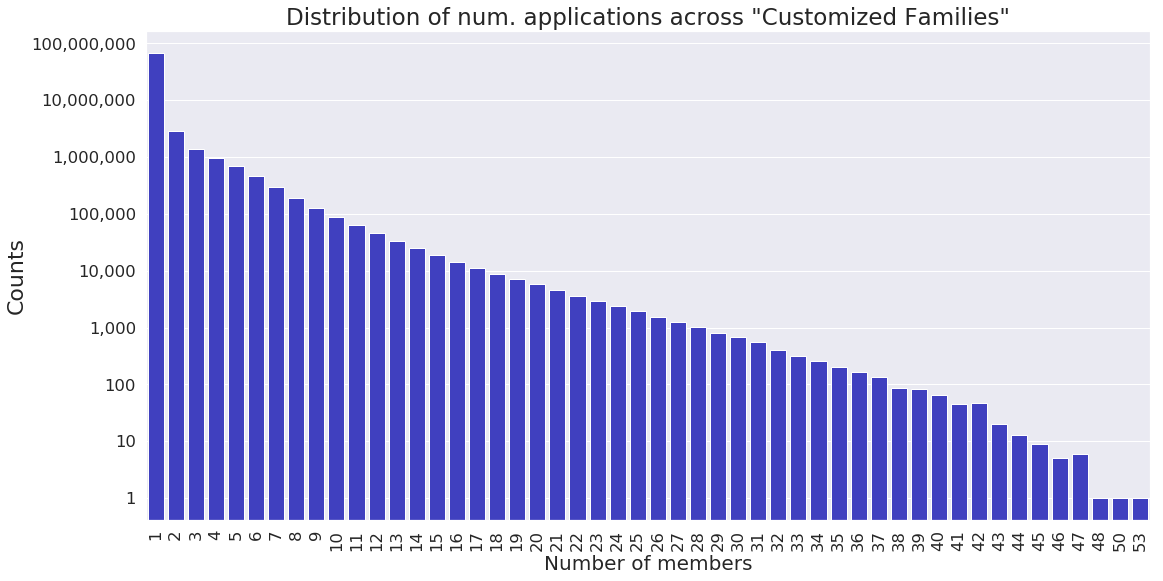

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))
sns.barplot(ax=ax, x="nb_members", y="freq_families", data=df_,
            color="blue", saturation=.5)
#ax.bar
ax.xaxis.set_tick_params(rotation=90)
ax.set_yscale('log')
ax.set_xlabel('Number of members', fontsize=20)
ax.set_ylabel('Counts', fontsize=22)
ax.set_title('Distribution of num. applications across "Customized Families"', fontsize=23)
#ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
#ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
#          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
#ax.set_yscale('log')
#ax.set_xticks(ax.get_xticks()) # list of xticks positions
#ax.set_xticklabels(ax.get_xticklabels(), fontdict={'fontsize':16}, rotation=45, ha='right') #or rotation='horizontal'

plt.show()

In [ ]:
## QUERY-1-C: Finding the distribution of number of members in each DOCDB_family_id, for comparing with the distribution of our customized family_id

In [ ]:
%%bigquery df_
WITH a AS(
    SELECT
        docdb_family_id AS family_id,
        COUNT(appln_id) AS nb_members
    FROM
        `usptobias.patstat.tls201`
    GROUP BY
        docdb_family_id
)

SELECT
    nb_members,
    COUNT(family_id) AS freq_families
FROM a
GROUP BY nb_members
ORDER BY nb_members

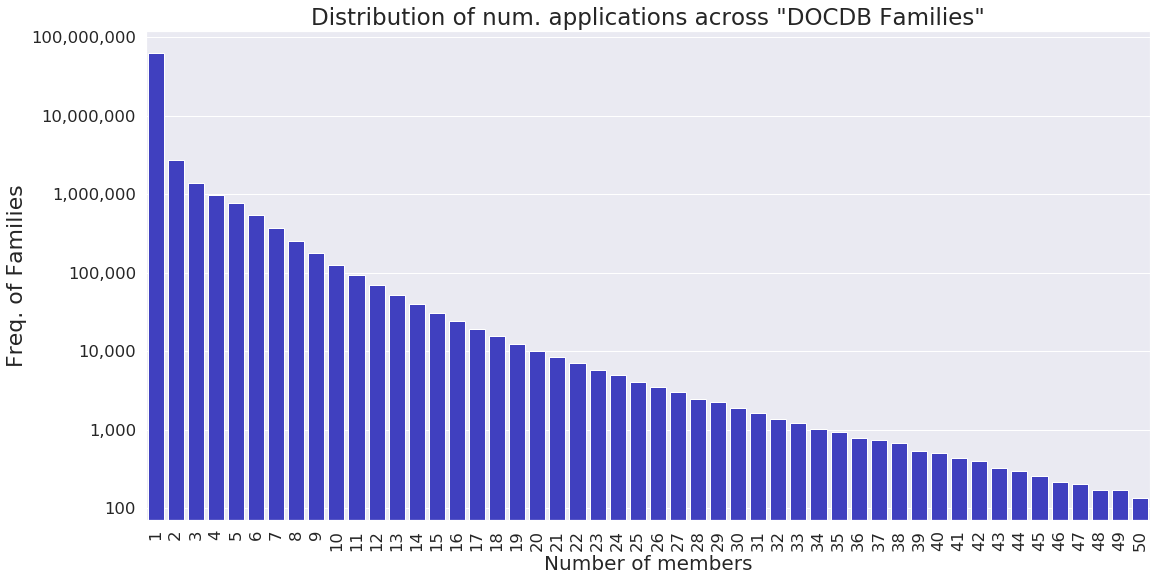

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(18,9))
sns.barplot(ax=ax, x="nb_members", y="freq_families", data=df_.iloc[:50,:],
            color="blue", saturation=.5)
#ax.bar
ax.xaxis.set_tick_params(rotation=90)
ax.set_yscale('log')
ax.set_xlabel('Number of members', fontsize=20)
ax.set_ylabel('Freq. of Families', fontsize=22)
ax.set_title('Distribution of num. applications across "DOCDB Families"', fontsize=23)
#ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [90]:
df_.head()

,nb_members,freq_families
0,1,62079193
1,2,2682781
2,3,1377096
3,4,987001
4,5,765771


In [92]:
print('THe number of families with more than 2 members: {:,}'.format(df_[df_.nb_members>1].freq_families.sum()))

THe number of families with more than 2 members: 7,702,934


# Investingating some samples that are in the same family

**What to do for tomorrow?**
1. Take a look at the code that you wrote for the last step (where you replacing the prior_appln_id by appln_id for the ones that has more than one member in their group_by_AP array. I think there is some mistake since you didn't calculate group_by_AP and I think you are using the previous results of group_by_AP, but I'm not sure)
2. Look at the results! Try to find exceptions (like seeing patents which has the same family_id but also they have the same "appln_auth"). Also, try to look at some random cases to see if the patents which are in the same family make sense to be considered as "Exact twins"!

In [ ]:
## QUERY-2-A: Finding the applications in the "Mechanical Engineering" technical field, using 'tls209' and 'tls201' tables
# and finally adding that information to our 'step_02_final' table with family_id information

In [ ]:
%%bigquery df_
WITH a AS(
  SELECT * 
  FROM(
    SELECT *
    FROM(
      SELECT appln_id, ipc_class_symbol
      FROM `usptobias.patstat.tls209`
      WHERE REGEXP_CONTAINS(ipc_class_symbol, r'.*F01B.*')
    ) AS t1
    INNER JOIN (
      SELECT appln_id, appln_filing_year, appln_kind, appln_nr
      FROM `usptobias.patstat.tls201`
    ) AS t2 USING(appln_id)
  )
  WHERE appln_filing_year>=2001 AND appln_filing_year<2010
)

SELECT *
FROM(
    SELECT t1.*, a.* EXCEPT(appln_id), t2.prior_appln_id
    FROM `usptobias.custom_alg.step_02_final` AS t1
    INNER JOIN a USING(appln_id)
    INNER JOIN `usptobias.patstat.tls204` AS t2 USING(appln_id)
)
INNER JOIN(
    SELECT family_id, COUNT(appln_id) AS cnt_family
    FROM `usptobias.custom_alg.step_02_final`
    GROUP BY family_id
    HAVING COUNT(appln_id)>1
) USING(family_id)
ORDER BY family_id
LIMIT 10000

In [23]:
df_.head()

,family_id,appln_id,appln_auth,ipc_class_symbol,appln_filing_year,appln_kind,appln_nr,prior_appln_id,cnt_family
0,17440,333354877,CN,F01B 3/04,2009,A,200980113793,17440,8
1,17440,457938321,UA,F01B 3/00,2009,A,201012301,17440,8
2,17440,58055494,WO,F01B 3/04,2009,W,2009050440,17440,8
3,17440,336156243,EA,F01B 3/04,2009,A,201071091,17440,8
4,17440,331452440,KR,F01B 3/04,2009,A,20107023071,17440,8


# 2. Validation of the results of Customized Algorithm

## 2.1. Cheking families with artificial applications: `family_id = 902034995`

**Let's explore the information of all applications that have the customized family_id of "902034995"**

In [68]:
## QUERY-2-B: Getting all the applications with "family_id=902034995", for the sake of exampling

In [56]:
%%bigquery
SELECT *
FROM (
    SELECT *
    FROM `usptobias.custom_alg.step_02_final`
    WHERE family_id=902034995
)
INNER JOIN(
    SELECT 
        appln_id, appln_auth AS appln_auth_2, appln_filing_year, appln_kind, appln_nr, 
        appln_nr_original, int_phase, reg_phase, nat_phase, earliest_filing_year, docdb_family_id, docdb_family_size
    FROM `usptobias.patstat.tls201`
) USING(appln_id)

,appln_id,appln_auth,family_id,appln_auth_2,appln_filing_year,appln_kind,appln_nr,appln_nr_original,int_phase,reg_phase,nat_phase,earliest_filing_year,docdb_family_id,docdb_family_size
0,13817721,DE,902034995,DE,2003,A,50309400,50309400,False,True,True,2002,30129267,8
1,15485538,DK,902034995,DK,2003,T,03405417,03405417,False,True,True,2002,30129267,8
2,40599677,KR,902034995,KR,2003,A,20030039159,1020030039159,False,False,True,2002,30129267,8
3,6968591,CN,902034995,CN,2003,A,03147186,B031471862,False,False,True,2002,30129267,8
4,42469056,PL,902034995,PL,2003,A,36113103,03 361131,False,False,True,2002,30129267,8
5,902034995,EP,902034995,EP,2002,A,02405579,,False,True,False,2002,902034995,1


**Now, let's look at the other family members with `docdb_family_id`=30129267. Also I will compare it to the list of patents that have `902034995` as their priority filing**

In [69]:
## QUERY-2-C: Getting all the patents application with "docdb_family_if = 30129267" to compare its members with our customized family_id

In [60]:
%%bigquery
SELECT
        appln_id, appln_auth AS appln_auth_2, appln_filing_year, appln_kind, appln_nr, 
        appln_nr_original, int_phase, reg_phase, nat_phase, earliest_filing_year, docdb_family_id, docdb_family_size
FROM `usptobias.patstat.tls201`
WHERE docdb_family_id=30129267
ORDER BY appln_auth

,appln_id,appln_auth_2,appln_filing_year,appln_kind,appln_nr,appln_nr_original,int_phase,reg_phase,nat_phase,earliest_filing_year,docdb_family_id,docdb_family_size
0,6968591,CN,2003,A,03147186,B031471862,False,False,True,2002,30129267,8
1,13817721,DE,2003,A,50309400,50309400,False,True,True,2002,30129267,8
2,15485538,DK,2003,T,03405417,03405417,False,True,True,2002,30129267,8
3,16031594,EP,2003,A,03405417,03405417,False,True,False,2002,30129267,8
4,333916434,JP,2010,A,2010261518,2010261518,False,False,True,2002,30129267,8
5,38167564,JP,2003,A,2003193406,2003193406,False,False,True,2002,30129267,8
6,40599677,KR,2003,A,20030039159,1020030039159,False,False,True,2002,30129267,8
7,42469056,PL,2003,A,36113103,03 361131,False,False,True,2002,30129267,8


In [70]:
## QUERY-2-D: Looking at all of the patent's applications with the same priority filings as "priority_appln_id = 902034995", 
# ...to compare it with "DOCDB_family_id" members and our custom "family_id" members

In [59]:
%%bigquery
SELECT 
        appln_id, appln_auth AS appln_auth_2, appln_filing_year, appln_kind, appln_nr, 
        appln_nr_original, int_phase, reg_phase, nat_phase, earliest_filing_year, docdb_family_id, docdb_family_size
FROM `usptobias.patstat.tls201`
INNER JOIN (
    SELECT appln_id, prior_appln_id
    FROM `usptobias.patstat.tls204`
    WHERE prior_appln_id=902034995
) USING(appln_id)
ORDER BY appln_auth

,appln_id,appln_auth_2,appln_filing_year,appln_kind,appln_nr,appln_nr_original,int_phase,reg_phase,nat_phase,earliest_filing_year,docdb_family_id,docdb_family_size
0,6968591,CN,2003,A,03147186,B031471862,False,False,True,2002,30129267,8
1,13817721,DE,2003,A,50309400,50309400,False,True,True,2002,30129267,8
2,15485538,DK,2003,T,03405417,03405417,False,True,True,2002,30129267,8
3,16031594,EP,2003,A,03405417,03405417,False,True,False,2002,30129267,8
4,333916434,JP,2010,A,2010261518,2010261518,False,False,True,2002,30129267,8
5,38167564,JP,2003,A,2003193406,2003193406,False,False,True,2002,30129267,8
6,40599677,KR,2003,A,20030039159,1020030039159,False,False,True,2002,30129267,8
7,42469056,PL,2003,A,36113103,03 361131,False,False,True,2002,30129267,8


**But by investigating the patents in the custom `"family_id"=902034995`, we see a lot of problems:**
1. First, the following application numbers cannot be found: "DK03405417" and "EP02405579" (By using Google Patents Public Dataset, I found out that this application is the priority of many other applications, but it does not have a publication number, thus there is no data in Google Patents Website. It was obvious from the beginning, since this application has appln_id>900,000,000)
2. Second, application "KR20030039159A" is not the same application as the others at all! (Using Google Patent Public Dateset, I was able to track down the right patent!- You can see in the second query below that there are three application numbers like together, but one of them has not the same priority application as we wanted)

Since all of the above problems were solved, now these are valid twins in fact!


In [71]:
## QUERY-2-E: Using Google Patent Public Dataset to retrieve all the patents applications with the same priority filings as "EP-02405579-A"

In [67]:
%%bigquery
SELECT *
FROM(
  SELECT
        a.application_number, a.publication_number, REGEXP_EXTRACT(a.application_number, r'.*-(\d*)-.*') AS appln_nr, 
        a.family_id, a.grant_date, country_code, kind_code, application_kind AS appln_kind, 
        PC.application_number AS priority_application_number, REGEXP_EXTRACT(PC.application_number, r'.*-(\d*)-.*') AS priority_appln_nr
  FROM `patents-public-data.patents.publications` AS a, UNNEST(priority_claim) AS PC
)
WHERE priority_appln_nr='02405579'
ORDER BY country_code
LIMIT 100

,application_number,publication_number,appln_nr,family_id,grant_date,country_code,kind_code,appln_kind,priority_application_number,priority_appln_nr
0,CN-03147186-A,CN-1470750-A,03147186,30129267,0,CN,A,A,EP-02405579-A,02405579
1,CN-03147186-A,CN-100379957-C,03147186,30129267,20080409,CN,C,A,EP-02405579-A,02405579
2,DE-50309400-A,DE-50309400-D1,50309400,30129267,20080430,DE,D1,A,EP-02405579-A,02405579
3,DK-03405417-T,DK-1380738-T3,03405417,30129267,20080421,DK,T3,T,EP-02405579-A,02405579
4,EP-03405417-A,EP-1380738-B1,03405417,30129267,20080319,EP,B1,A,EP-02405579-A,02405579
5,EP-03405417-A,EP-1380738-A1,03405417,30129267,0,EP,A1,A,EP-02405579-A,02405579
6,JP-2010261518-A,JP-2011064201-A,2010261518,30129267,0,JP,A,A,EP-02405579-A,02405579
7,JP-2003193406-A,JP-2004044594-A,2003193406,30129267,0,JP,A,A,EP-02405579-A,02405579
8,KR-20030039159-A,KR-101045920-B1,20030039159,30129267,20110701,KR,B1,A,EP-02405579-A,02405579
9,KR-20030039159-A,KR-20040005589-A,20030039159,30129267,0,KR,A,A,EP-02405579-A,02405579


In [72]:
## QUERY-2-F: Investigating all of the patent's applications with the same application number as "KR-20030039159"

In [66]:
%%bigquery
SELECT *
FROM(
  SELECT 
      a.application_number, a.publication_number, REGEXP_EXTRACT(a.application_number, r'.*-(\d*)-.*') AS appln_nr, country_code, kind_code, application_kind AS appln_kind, 
      PC.application_number AS priority_application_number, REGEXP_EXTRACT(PC.application_number, r'.*-(\d*)-.*') AS priority_appln_nr
  FROM `patents-public-data.patents.publications` AS a, UNNEST(priority_claim) AS PC
)
WHERE appln_nr='20030039159'
ORDER BY country_code
LIMIT 1000

,application_number,publication_number,appln_nr,country_code,kind_code,appln_kind,priority_application_number,priority_appln_nr
0,KR-20030039159-A,KR-101045920-B1,20030039159,KR,B1,A,EP-02405579-A,02405579
1,KR-20030039159-U,KR-200346051-Y1,20030039159,KR,Y1,U,KR-20030039159-U,20030039159
2,KR-20030039159-A,KR-20040005589-A,20030039159,KR,A,A,EP-02405579-A,02405579


**By looking at "QUERY-3-A" above, we see an interesting event! The application number "EP-03405417-A" has the same priority of "EP-02405579-A" but as we investigated in 'QUERY-2-B', it doesn't exists in PatStat!**

In summary, after taking care of minor points discussed above, we were able to validate that infact all of the above applications were exact twins!

## 2.2. Investigating Families with at least one 'US' member

We take the result of "QUERY-2-A" and only keep the applications from `US` "appln_auth"

In [101]:
df_[df_.appln_auth=='US'].drop_duplicates(subset=['family_id', 'appln_id', 'appln_auth'], keep='first').head()

,family_id,appln_id,appln_auth,ipc_class_symbol,appln_filing_year,appln_kind,appln_nr,cnt_family
8,17441,332856209,US,F01B 7/04,2009,A,73618309,12
25,72673,274357034,US,F01B 21/04,2008,A,45019108,4
27,85902,325208507,US,F01B 3/00,2008,A,66800008,5
28,116844,338781907,US,F01B 9/00,2009,A,73758509,3
32,138643,45561899,US,F01B 13/06,2001,A,981201,7


In [ ]:
# QUERY-2-G: Checking if the granted information is correct in Patstat for this example by getting all of its members

In [97]:
%%bigquery
SELECT a.appln_id, a.appln_nr, a.appln_nr_original, a.appln_auth, a.appln_filing_year, a.granted, b.family_id
FROM `usptobias.patstat.tls201` AS a
INNER JOIN(
    SELECT *
    FROM `usptobias.custom_alg.step_02_final`
    WHERE family_id=17441
    ORDER BY appln_auth
) AS b USING(appln_id)
ORDER BY appln_auth

,appln_id,appln_nr,appln_nr_original,appln_auth,appln_filing_year,granted,family_id
0,332388962,200980109539,2009801095398,CN,2009,True,17441
1,336156244,201071092,201071092,EA,2009,True,17441
2,267541145,09726995,09726995,EP,2009,True,17441
3,380390282,09726995,09726995,ES,2009,True,17441
4,17441,0801437,0801437,FR,2008,False,17441
5,331954651,20814910,208149,IL,2010,True,17441
6,334541923,2011500270,2011500270,JP,2009,True,17441
7,332346431,20107023073,1020107023073,KR,2009,True,17441
8,457938319,201012300,A201012300,UA,2009,True,17441
9,332856209,73618309,12736183,US,2009,True,17441


**Note that application with `appln_id` of "17441" does not exists in "QUERY-2-A" results. This is because of the fact that this application has a different `IPC_technical_symbol` than the rest of this family!**

In [104]:
# Looking at the results of QUERY-2-A conditioning on "family_id=17441"
df_[df_.family_id==17441].drop_duplicates(subset=['family_id', 'appln_id']).sort_values(by=['appln_auth']).reset_index(drop=True)

,family_id,appln_id,appln_auth,ipc_class_symbol,appln_filing_year,appln_kind,appln_nr,cnt_family
0,17441,332388962,CN,F01B 3/04,2009,A,200980109539,12
1,17441,336156244,EA,F01B 3/04,2009,A,201071092,12
2,17441,267541145,EP,F01B 3/04,2009,A,09726995,12
3,17441,380390282,ES,F01B 3/04,2009,T,09726995,12
4,17441,332346431,KR,F01B 3/04,2009,A,20107023073,12
5,17441,457938319,UA,F01B 3/00,2009,A,201012300,12
6,17441,332856209,US,F01B 7/04,2009,A,73618309,12
7,17441,58055497,WO,F01B 3/04,2009,W,2009050443,12


In [ ]:
# QUERY-2-H: getting the IPC technical field of application ID "17441"

In [94]:
%%bigquery
SELECT b.*, a.ipc_class_symbol
FROM `usptobias.patstat.tls209` AS a
INNER JOIN(
    SELECT appln_id, appln_nr, appln_nr_original, appln_auth, appln_filing_year, granted
    FROM `usptobias.patstat.tls201`
    WHERE appln_id=17441
) AS b USING(appln_id)

,appln_id,appln_nr,appln_nr_original,appln_auth,appln_filing_year,granted,ipc_class_symbol
0,17441,0801437,0801437,FR,2008,False,F02B 75/28
1,17441,0801437,0801437,FR,2008,False,F02D 15/02
2,17441,0801437,0801437,FR,2008,False,F02B 75/32



**Thus, there exists "12" members in this family! Let's now investigate whether they cover the same invention or not!**

It's really easier to find them if we can cross-refrence them with the patents in "Google Patents Public Dataset". So, let's retrieve all the patents which are pointing to application number `0801437`

In [102]:
## QUERY-2-I: Using Google Patent Public Dataset to retrieve all the patents applications with the same priority filings as "FR-0801437"

In [3]:
%%bigquery df_s
SELECT *
FROM(
  SELECT
        a.application_number, a.publication_number, REGEXP_EXTRACT(a.application_number, r'.*-(\d*)-.*') AS appln_nr, 
        a.family_id, a.publication_date, a.grant_date, country_code, kind_code, application_kind AS appln_kind, 
        PC.application_number AS priority_application_number, REGEXP_EXTRACT(PC.application_number, r'.*-(\d*)-.*') AS priority_appln_nr
  FROM `patents-public-data.patents.publications` AS a, UNNEST(priority_claim) AS PC
)
WHERE priority_appln_nr='0801437'
ORDER BY country_code
LIMIT 100

,application_number,publication_number,appln_nr,family_id,publication_date,grant_date,country_code,kind_code,appln_kind,priority_application_number,priority_appln_nr
0,CN-200980109539-A,CN-101983278-A,200980109539,39563417,20110302,0,CN,A,A,FR-0801437-A,0801437
1,CN-200980109539-A,CN-101983278-B,200980109539,39563417,20140507,20140507,CN,B,A,FR-0801437-A,0801437
2,EA-201071092-A,EA-201071092-A1,201071092,39563417,20110429,0,EA,A1,A,FR-0801437-A,0801437
3,EA-201071092-A,EA-017522-B1,201071092,39563417,20130130,0,EA,B1,A,FR-0801437-A,0801437
4,EP-09726995-A,EP-2281107-B1,09726995,39563417,20120711,20120711,EP,B1,A,FR-0801437-A,0801437
5,EP-09726995-A,EP-2281107-A2,09726995,39563417,20110209,0,EP,A2,A,FR-0801437-A,0801437
6,ES-09726995-T,ES-2394594-T3,09726995,39563417,20130204,20130204,ES,T3,T,FR-0801437-A,0801437
7,FR-0801437-A,FR-2928694-A1,0801437,39563417,20090918,0,FR,A1,A,FR-0801437-A,0801437
8,GB-0801437-A,GB-0801437-D0,0801437,39186373,20080305,0,GB,D0,A,GB-0801437-A,0801437
9,IL-20814910-A,IL-208149-A,20814910,39563417,20131128,0,IL,A,A,FR-0801437-A,0801437


From the results above, we can see that we were able to retrieve all the patents that were exists in our family. The only difference is the application in the "GB" jurisdiction with appln_nr of "GB-0801437-A", which we can see that has different prior_appln_nr that the others. Thus, is not in the same family!

In [ ]:
## QUERY-2-J: Looking at the information of "GB-0801437-A" from PatStat to make sure it doesn't have the same priority as the others

In [5]:
%%bigquery
SELECT a.*, b.prior_appln_id
FROM(
    SELECT appln_id, appln_nr, appln_auth, appln_filing_year, granted
    FROM `usptobias.patstat.tls201`
    WHERE appln_nr='0801437'
) AS a
LEFT JOIN `usptobias.patstat.tls204` AS b USING(appln_id)

,appln_id,appln_nr,appln_auth,appln_filing_year,granted,prior_appln_id
0,21542697,0801437,GB,2008,False,None
1,17441,0801437,FR,2008,False,None


**Now, we try to look at the claims of patents for each jurisdiction:**

| Claims/Jurisdictions | FR (\*) | ES | EP | EA | IL | CN | JP | KR | UA | US | WO | ZA |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Publication Number | FR-2928694-A1 | ES-2394594-T3 | EP-2281107-B1 | EA-017522-B1 | IL-208149-A | CN-101983278-B | JP-5715043-B2 | KR-101617477-B1 | UA-104859-C2 | US-9388695-B2 | WO-2009122089-A3 | ZA-201007308-B |
| Granted | No | Yes ** | Yes ** | No | No | Yes ** | Yes ** | Yes ** | No | Yes ** | No | No |
| Abstract | (Base) | Almost the same | Same | Same | Same | Same | NA | Almost the same | Same | Same | Same | NA |
| 1st Claim | 1 | 1 | 1 | NA | NA | 1 | 1 | 1 | NA | 1 | NA | NA |
| 2nd Claim | 2 | 1 | 1 | NA | NA | 1 | 1 | 1 | NA | 1 | NA | NA |
| 3rd Claim | 3 | 2 | 2 | NA | NA | 2 | 2 | 2 | NA | 2 | NA | NA |
| 4th Claim | 4 | 3 | 3 | NA | NA | 3 | 3 | 3 | NA | 3 | NA | NA |
| 5th Claim | 5 | 4 | 4 | NA | NA | 4 | 4 | 4 | NA | 4 | NA | NA |
| 6th Claim | 6 | 5 | 5 | NA | NA | 5 | 5 | 5 | NA | 5 | NA | NA |
| 7th Claim | 7 | 6 | 6 | NA | NA | 6 | 6 | 6 | NA | 6 | NA | NA |
| 8th Claim | 8 | 1 | 1 | NA | NA | 1 | 1 | 1 | NA | 1 | NA | NA |
| 9th Claim | 9 | 1 | 1 | NA | NA | 1 | 1 | 1 | NA | 1 | NA | NA |
| 10th Claim | 10 | 7 | 7 | NA | NA | 7 | 7 | 7 | NA | 7 | NA | NA |
| 11th Claim | 11 | 8 | 8 | NA | NA | 8 | 8 | 8 | NA | 8 | NA | NA |
| 12th Claim | 12 | 9 | 9 | NA | NA | 9 | 9 | 9 | NA | 9 | NA | NA |
| 13th Claim | 13 | 10 | 10 | NA | NA | 10 | 10 | 10 | NA | 10 | NA | NA |
| 14th Claim | 14 | 11 | 11 | NA | NA | 11 | 11 | 11 | NA | 11 | NA | NA |
| 15th - 23th Claim | - | - | - | NA | NA | - | - | - | NA | 12-20 | NA | NA |

* \* This is the priority application
* \*\* Thee are the granted patent applications

## 2.3. Investigating a family with a `US` patent and different priorities (first sample):

In [68]:
df_varPrior = df_[df_.family_id!=df_.prior_appln_id].drop_duplicates(subset=['family_id', 'appln_id', 'appln_nr'])
df_varPrior.head()

,family_id,appln_id,appln_auth,ipc_class_symbol,appln_filing_year,appln_kind,appln_nr,prior_appln_id,cnt_family
22,71236,328051562,JP,F01B 11/00,2008,A,2010513734,901577609,4
28,72673,274357034,US,F01B 21/04,2008,A,45019108,55544732,4
30,85902,325208507,US,F01B 3/00,2008,A,66800008,901576706,5
33,121652,317666036,JP,F01B 21/02,2008,A,2009552764,46844232,6
39,138643,45561899,US,F01B 13/04,2001,A,981201,902914498,7


In [ ]:
## QUERY-2-K: Getting the information of the family "72673", has one 'US' application which contains several priors

In [40]:
%%bigquery
SELECT a.*, b.appln_nr, b.appln_filing_year, b.granted ,CAST(c.prior_appln_id AS STRING) AS prior_appln_id
FROM (
    SELECT *
    FROM `usptobias.custom_alg.step_02_final`
    WHERE (family_id=72673) OR (appln_id=55233300) OR (appln_id=55544732)
) AS a
LEFT JOIN `usptobias.patstat.tls201` AS b USING(appln_id)
LEFT JOIN `usptobias.patstat.tls204` AS c USING(appln_id) 
ORDER BY family_id, appln_auth

,appln_id,appln_auth,family_id,appln_nr,appln_filing_year,granted,prior_appln_id
0,274702168,CN,72673,200880011231,2008,True,55233300
1,274702168,CN,72673,200880011231,2008,True,55544732
2,54949232,EP,72673,08737383,2008,True,55233300
3,54949232,EP,72673,08737383,2008,True,55544732
4,274357034,US,72673,45019108,2008,True,55233300
5,274357034,US,72673,45019108,2008,True,55544732
6,72673,WO,72673,2008000812,2008,False,55544732
7,72673,WO,72673,2008000812,2008,False,55233300
8,55233300,JP,55233300,2007100080,2007,True,None
9,55544732,JP,55544732,2007127128,2007,True,None


In [ ]:
## QUERY-2-L: 

In [ ]:
%%bigquery df_s
SELECT *
FROM(
  SELECT
        a.application_number, a.publication_number, REGEXP_EXTRACT(a.application_number, r'.*-(\d*)-.*') AS appln_nr, 
        a.family_id, a.publication_date, a.grant_date, country_code, kind_code, application_kind AS appln_kind, 
        PC.application_number AS priority_application_number, REGEXP_EXTRACT(PC.application_number, r'.*-(\d*)-.*') AS priority_appln_nr
  FROM `patents-public-data.patents.publications` AS a, UNNEST(priority_claim) AS PC
)
WHERE (priority_application_number LIKE 'JP%2007100080%') OR (priority_application_number LIKE 'JP%2007127128%')
ORDER BY country_code
LIMIT 100

In [65]:
df_s.sort_values(by=['grant_date'], ascending=False)\
    .drop_duplicates(subset=['appln_nr'], keep='first').sort_values(by=['application_number', 'country_code'])

,application_number,publication_number,appln_nr,family_id,publication_date,grant_date,country_code,kind_code,appln_kind,priority_application_number,priority_appln_nr
0,CN-200880011231-A,CN-101652551-B,200880011231,39978639,20121031,20121031,CN,B,A,JP-2007100080-A,2007100080
6,EP-08737383-A,EP-2145092-B1,08737383,39831474,20121017,20121017,EP,B1,A,JP-2007100080-A,2007100080
18,IB-2008000812-W,WO-2008122866-A2,2008000812,39831474,20081016,0,WO,A2,W,JP-2007100080-A,2007100080
11,JP-2007100080-A,JP-4265675-B2,2007100080,39978639,20090520,20090520,JP,B2,A,JP-2007100080-A,2007100080
8,JP-2007127128-A,JP-4321623-B2,2007127128,40141977,20090826,20090826,JP,B2,A,JP-2007127128-A,2007127128
15,US-45019108-A,US-8291697-B2,45019108,39831474,20121023,20121023,US,B2,A,JP-2007100080-A,2007100080


| Claims/Jurisdictions | JP (\*) | JP (\*) | US | CN | EP | WO |
| --- | --- | --- | --- | --- | --- | --- |
| Publication Number | JP-4265675-B2 | JP-4321623-B2 | US-8291697-B2 | CN-101652551-B | EP-2145092-B1 | WO-2008122866-A2 |
| Granted | No | Yes ** | Yes ** | Yes ** | Yes ** | Yes ** | No |
| Abstract | NA | NA | (Base) | Same | NA | Same | 
| 1st Claim | 1 | - | 1 | 1 | 1 | 1 | 
| 2nd Claim | 2 | - | 2 | 2 | 2 | 2 | 
| 3rd Claim | - | 1 | 3 | 3 | 3 | 3 | 
| 4th Claim | - | 1 | 4 | 4 | 4 | 4 |


* \* These are the primary priority applications
* \*\* Thee are the granted patent applications

## 2.4. Investigating a family with a `US` patent and different priorities (second sample):

In [76]:
import random
random.seed(999)
start_rnd = random.randint(0,df_varPrior.shape[0])
df_varPrior.iloc[start_rnd:,:].head(5)

,family_id,appln_id,appln_auth,ipc_class_symbol,appln_filing_year,appln_kind,appln_nr,prior_appln_id,cnt_family
4884,902975508,3497761,BR,F01B 31/14,2003,A,0300724,38037505,10
4887,902975508,416266165,KR,F01B 31/14,2003,A,20030017553,38037505,10
4890,902975508,45187860,TW,F01B 31/14,2003,A,92105952,38037505,10
4896,902975508,15997183,EP,F01B 31/14,2003,A,03006026,38037505,10
4899,902975508,41322288,MX,F01B 9/04,2003,A,PA03002422,38037505,10


In [ ]:
## QUERY-2-M: Getting the information of the family "72673", has one 'US' application which contains several priors

In [79]:
%%bigquery
SELECT a.*, b.appln_nr, b.appln_filing_year, b.granted ,CAST(c.prior_appln_id AS STRING) AS prior_appln_id
FROM (
    SELECT *
    FROM `usptobias.custom_alg.step_02_final`
    WHERE (family_id=902975508) OR (appln_id=38037505) OR (appln_id=902975508)
) AS a
LEFT JOIN `usptobias.patstat.tls201` AS b USING(appln_id)
LEFT JOIN `usptobias.patstat.tls204` AS c USING(appln_id) 
ORDER BY appln_auth, prior_appln_id

,appln_id,appln_auth,family_id,appln_nr,appln_filing_year,granted,prior_appln_id
0,2573818,AU,902975508,2003201327,2003,True,38037505
1,2573818,AU,902975508,2003201327,2003,True,902975508
2,3497761,BR,902975508,0300724,2003,True,38037505
3,3497761,BR,902975508,0300724,2003,True,902975508
4,4794575,CA,902975508,2422663,2003,True,38037505
5,4794575,CA,902975508,2422663,2003,True,902975508
6,15997183,EP,902975508,03006026,2003,True,38037505
7,15997183,EP,902975508,03006026,2003,True,902975508
8,17681908,ES,902975508,03006026,2003,True,38037505
9,17681908,ES,902975508,03006026,2003,True,902975508


In [ ]:
## QUERY-2-N: 

In [ ]:
%%bigquery df_s
SELECT *
FROM(
  SELECT
        a.application_number, a.publication_number, REGEXP_EXTRACT(a.application_number, r'.*-(\d*)-.*') AS appln_nr, 
        a.family_id, a.publication_date, a.grant_date, country_code, kind_code, application_kind AS appln_kind, 
        PC.application_number AS priority_application_number, REGEXP_EXTRACT(PC.application_number, r'.*-(\d*)-.*') AS priority_appln_nr
  FROM `patents-public-data.patents.publications` AS a, UNNEST(priority_claim) AS PC
)
WHERE (priority_application_number LIKE 'JP%2002079736%') OR (application_number LIKE 'JP%2002079736%')
ORDER BY country_code
LIMIT 100

In [86]:
df_s.sort_values(by=['grant_date'], ascending=False)\
    .drop_duplicates(subset=['application_number'], keep='first').sort_values(by=['application_number', 'country_code'])

,application_number,publication_number,appln_nr,family_id,publication_date,grant_date,country_code,kind_code,appln_kind,priority_application_number,priority_appln_nr
1,AU-2003201327-A,AU-2003201327-B2,2003201327,27791046,20080821,20080821,AU,B2,A,JP-2002079736-A,2002079736
3,BR-0300724-A,BR-0300724-B1,0300724,27791046,20120417,0,BR,B1,A,JP-2002079736-A,2002079736
4,CA-2422663-A,CA-2422663-C,2422663,27791046,20070213,20070213,CA,C,A,JP-2002079736-A,2002079736
8,CN-03120815-A,CN-1268838-C,03120815,27791046,20060809,20060809,CN,C,A,JP-2002079736-A,2002079736
7,CN-03242297-U,CN-2700581-Y,03242297,27791046,20050518,20050518,CN,Y,U,JP-2002079736-A,2002079736
9,DE-60316372-T,DE-60316372-T2,60316372,27791046,20080612,20080612,DE,T2,T,JP-2002079736-A,2002079736
12,EP-03006026-A,EP-1347159-B1,03006026,27791046,20070919,20070919,EP,B1,A,JP-2002079736-A,2002079736
14,ES-03006026-T,ES-2294210-T3,03006026,27791046,20080401,20080401,ES,T3,T,JP-2002079736-A,2002079736
15,JP-2003050641-A,JP-2003343297-A,2003050641,27791046,20031203,0,JP,A,A,JP-2002079736-A,2002079736
17,KR-20030017553-A,KR-100474424-B1,20030017553,27791046,20050309,20050309,KR,B1,A,JP-2002079736-A,2002079736


**In the above example, we can see that there are two applications in "China" which were correctly removed from "exact twins" family ID.**

| Claims/Jurisdictions | JP (\*) | JP | US | KR | EP | ES | AU | CA | BR | MX | TW 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Publication Number | NA | JP-2003343297-A | US-6820586-B2 | KR-100474424-B1 | EP-1347159-B1 | ES-2294210-T3 | AU-2003201327-B2 | CA-2422663-C | BR-0300724-A | MX-PA03002422-A | TW-583382-B |
| Granted | - | No | Yes ** | Yes ** | Yes ** | Yes ** | Yes ** | Yes ** | No | No | Yes ** |
| Abstract | NA | NA | (Base) | Almost Same | NA | Almost the Same | NA | Same | Same | NA | Same |
| 1st Claim | NA | - | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 
| 2nd Claim | NA | - | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 2 | 
| 3rd Claim | NA | - | 3 | 3 | 3 | 3 | 3 | 3 | 3 | 3 | 3 | 3 | 3 | 
| 4th Claim | NA | - | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 | 4 |
| 5th Claim | NA | - | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 | 5 |


* \* These are the primary priority applications
* \*\* Thee are the granted patent applications

# 3. Creating Exact twins Dataset

In [49]:
t1='`usptobias.custom_alg.step_02_PCT`'
t2='`usptobias.patstat.tls201`'

client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id = 'step_03_twins'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref
query="""
WITH us_pat AS(
    SELECT a.appln_id, a.appln_auth, b.appln_filing_year, b.granted, a.family_id
    FROM(
        SELECT appln_id, appln_auth, family_id
        FROM {}
        WHERE appln_auth='US'    
    ) AS a
    LEFT JOIN {} AS b USING(appln_id)

), oth_pat AS(
    SELECT a.appln_id, a.appln_auth, b.appln_filing_year, b.granted, a.family_id
    FROM(
        SELECT appln_id, appln_auth, family_id
        FROM {}
        WHERE appln_auth<>'US'
    ) AS a
    LEFT JOIN {} AS b USING(appln_id)
)

SELECT 
    a.appln_id AS appln_id_1,
    a.appln_auth AS appln_auth_1,
    a.appln_filing_year AS appln_filing_year_1,
    a.granted AS granted_1,
    b.appln_id AS appln_id_2,
    b.appln_auth AS appln_auth_2,
    b.appln_filing_year AS appln_filing_year_2,
    b.granted AS granted_2,
    b.family_id
FROM us_pat AS a
LEFT JOIN oth_pat AS b USING(family_id)
""".format(t1,t2,t1,t2)

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

# 3. Running the same algorithm on "Google Patent Public Dataset"

In [7]:
client = bigquery.Client()
# Creating Job Config
job_config = bigquery.QueryJobConfig()
#job_config.dry_run = True
job_config.use_query_cache = False
# Set configuration.query.writeDisposition
job_config.write_disposition = 'WRITE_TRUNCATE'

# Set the destination table
dataset_id = 'custom_alg'
table_id = 'tls204_google'
table_ref = client.dataset(dataset_id).table(table_id)
job_config.destination = table_ref
query="""
WITH a AS(
  SELECT a.application_number AS appln_nr, country_code AS appln_auth, PC.application_number AS priority_appln_nr
  FROM `patents-public-data.patents.publications` AS a, UNNEST(a.priority_claim) AS PC
), b AS(
  SELECT 
    REGEXP_EXTRACT(appln_nr, r'\w{2}-(.*)-.*') AS appln_nr,
    REGEXP_EXTRACT(priority_appln_nr, r'\w{2}-(.*)-.*') AS priority_appln_nr,
    REGEXP_EXTRACT(priority_appln_nr, r'(\w{2})-.*-.*') AS priority_appln_auth,
    appln_auth
  FROM a
), c AS(
    SELECT appln_id, appln_nr, appln_auth
    FROM `usptobias.patstat.tls201` 
), d AS(
  SELECT DISTINCT
    t2.appln_id, t1.appln_nr, t1.appln_auth, t1.priority_appln_nr, t1.priority_appln_auth
  FROM b AS t1
  INNER JOIN c AS t2 USING(appln_nr, appln_auth)
), e AS(
  SELECT DISTINCT
    d.*,
    c.appln_id AS prior_appln_id
  FROM d
  INNER JOIN c ON (d.priority_appln_nr=c.appln_nr) AND (d.priority_appln_auth=c.appln_auth)
)

SELECT *
FROM e

"""

# Defining the query
query_job = client.query(query, location='US', job_config=job_config)

query_job.result()

In [ ]:
# Here, I try to get the unique "appln_nr" first by choosing the ones that hase been granted, otherwise choosing the latest publication

In [ ]:
%%bigquery

WITH a AS(
    SELECT
        aa.application_number, aa.publication_number, REGEXP_EXTRACT(aa.application_number, r'.*-(\d*)-.*') AS appln_nr, 
        aa.family_id, aa.publication_date, aa.grant_date, country_code, kind_code, application_kind AS appln_kind, 
        PC.application_number AS priority_application_number, REGEXP_EXTRACT(PC.application_number, r'.*-(\d*)-.*') AS priority_appln_nr
    FROM `patents-public-data.patents.publications` AS aa, UNNEST(priority_claim) AS PC
), b AS(
    SELECT a.*
    FROM a
    INNER JOIN(
        SELECT
            appln_nr, MAX(grant_date) AS grant_date
        FROM a
        WHERE grant_date<>0
        GROUP BY appln_nr    
    ) USING(appln_nr, grant_date)

), c AS(
    SELECT a.*
    FROM a
    LEFT JOIN b ON a.appln_nr=b.appln_nr
    WHERE b.appln_nr IS NULL
), d AS(
    SELECT a.*
    FROM a
    INNER JOIN(
        SELECT appln_nr, MAX(publication_date) AS publication_date
        FROM c
        GROUP BY appln_nr
    ) USING(appln_nr, publication_date)
)

SELECT * FROM b UNION ALL
SELECT * FROM d
LIMIT 100

In [47]:
%%bigquery
#standardSQL
WITH a AS (
    SELECT 1 AS id, [2,4,8] AS a_arr, [1,2,3,4] AS b_arr UNION ALL
    SELECT 2 AS id, [2,4,8], [1,2,3,4] UNION ALL
    SELECT 2, [2,5], [2,3,5,6] UNION ALL
    SELECT 3, [2,5], [2]

)
SELECT a.id, a_arr, b_arr, (CASE WHEN z=0 THEN 1 ELSE 0 END) AS update
FROM a , UNNEST([(
                SELECT ARRAY_LENGTH(a.a_arr) - COUNT(1) 
                FROM UNNEST(a.a_arr) AS x
                JOIN UNNEST(a.b_arr) AS y
                ON x=y)]) AS z
#WHERE z = 0

#SELECT *
#                      FROM (SELECT x FROM a, UNNEST(a.a_arr) AS x)
#                      JOIN (SELECT y FROM b, UNNEST(b.b_arr)  AS y)
#                      ON x = y


,id,a_arr,b_arr,update
0,1,"[2, 4, 8]","[1, 2, 3, 4]",0
1,2,"[2, 4, 8]","[1, 2, 3, 4]",0
2,2,"[2, 5]","[2, 3, 5, 6]",1
3,3,"[2, 5]",[2],0
